In [1]:
import numpy as np
import scipy.io.wavfile as wav
import scipy.signal as signal
import scipy.fft
import numpy as np
import matplotlib.pyplot as plt
import statistics
import math
import itertools
from PIL import Image
from copy import copy
from bisect import bisect

In [2]:
def load_image(file, image_width):
    data = np.load(file)
    img = np.reshape(data, (len(data)//image_width, image_width))
    image = np.zeros((img.shape[0], img.shape[1], 3), dtype=img.dtype)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image[i][j][1] = img[i][j]
    return image

In [3]:
def _get_telemetry_cadres(n: int, tel):
    one_pixel_tel = [pixel[0][1] for pixel in tel]
    telemetry = []
    for p in range(0, len(one_pixel_tel), 8):
        telemetry.append(one_pixel_tel[p])
    
    if n - 8 < 0:
        first_cadre = [telemetry[0:n + 7],]
    
    i = n + 7
        
    cadres = [telemetry[k:k+16] for k in range(i, len(telemetry), 16)]
    return first_cadre + cadres


def _get_zeros(cadres: list):
    zeros = []
    for cadre in cadres:
        try:
            zeros.append(cadre[-8])
        except IndexError:
            pass
    return zeros
  
    
def _find_number_of_cadr(i, cadres):
    left_bound, right_bound = 0, 0
    for cadr in cadres:
        right_bound += len(cadr) * 8 + 1
        if i >= left_bound and i < right_bound:
            return cadres.index(cadr)
        left_bound = right_bound
    raise RuntimeError
    
    
def _get_brightness(i: int, j: int, cadres, img):
    pixel = img[i][j][1]
    print("RGB = [0 %s 0]" % pixel)
    num = _find_number_of_cadr(i, cadres)
    print("Номер кадра = %s" % num)
    cadr = cadres[num]
    print("Кадр = %s" % cadr)
    index = bisect(cadr[0:9], pixel)
    print("Номер клина для этого пикселя = %s\n" % index)
    return pixel, cadr
    

In [ ]:
_get_telemetry_cadres(8: int, tel)

In [4]:
all_d = [[276.6067, 0.051111, 1.405783e-06],[276.6119, 0.051090, 1.496037e-06],[276.6311, 0.051033, 1.496990e-06], [276.6268, 0.051058, 1.493110e-06]]
A = 1.67396
B = 0.997364
b = [1, 1, 1, 1]
c = [1.1910427e-05, 1.4387752]
ve, vc = 2670, 2670

def _get_tbb(all_c_prt: list):
    all_t_prt = []
    for i in range(len(all_c_prt)):
        c_prt = all_c_prt[i]
        d = all_d[i]
        t_prt = d[0] + d[1]*c_prt + d[2]*(c_prt**2)
        all_t_prt.append(t_prt)
    assert len(all_t_prt) == 4
    ans = sum(all_t_prt)/4
    print("T_bb = %s" % ans)
    return ans


def _get_tbb_star(tbb: float):
    return A + B*tbb


def _get_nbb(tbb):
    tbb_star = _get_tbb_star(tbb)
    ans = c[0]*(ve**3) / (math.exp(c[1]*vc/tbb_star) - 1)
    print("N_bb = %s" % ans)
    return ans


def _get_nlin(ce, cadr):
    tbb = _get_tbb(cadr[-7:-3])
    nbb = _get_nbb(tbb)
    cbb = sum(cadr[-7:-3]) / 4
    print("Cbb = %s" % cbb)
    cs = cadr[-2]
    print("Cspace = %s\n" % cs)
    return nbb * (cs - ce)/(cs - cbb)

def get_te(ce, cadr):
    nlin = _get_nlin(ce, cadr)
    ne = nlin + b[0] + b[1]*nlin + b[2]*(nlin**2)
    te_star = c[1] * vc / (math.log(1 + (c[0] * (vc**3)/ne)))
    te = (te_star - A)/B
    print("Te = %s К" % te)
    print("Te = %s C" % (te - 273))
    return te

### python_demod

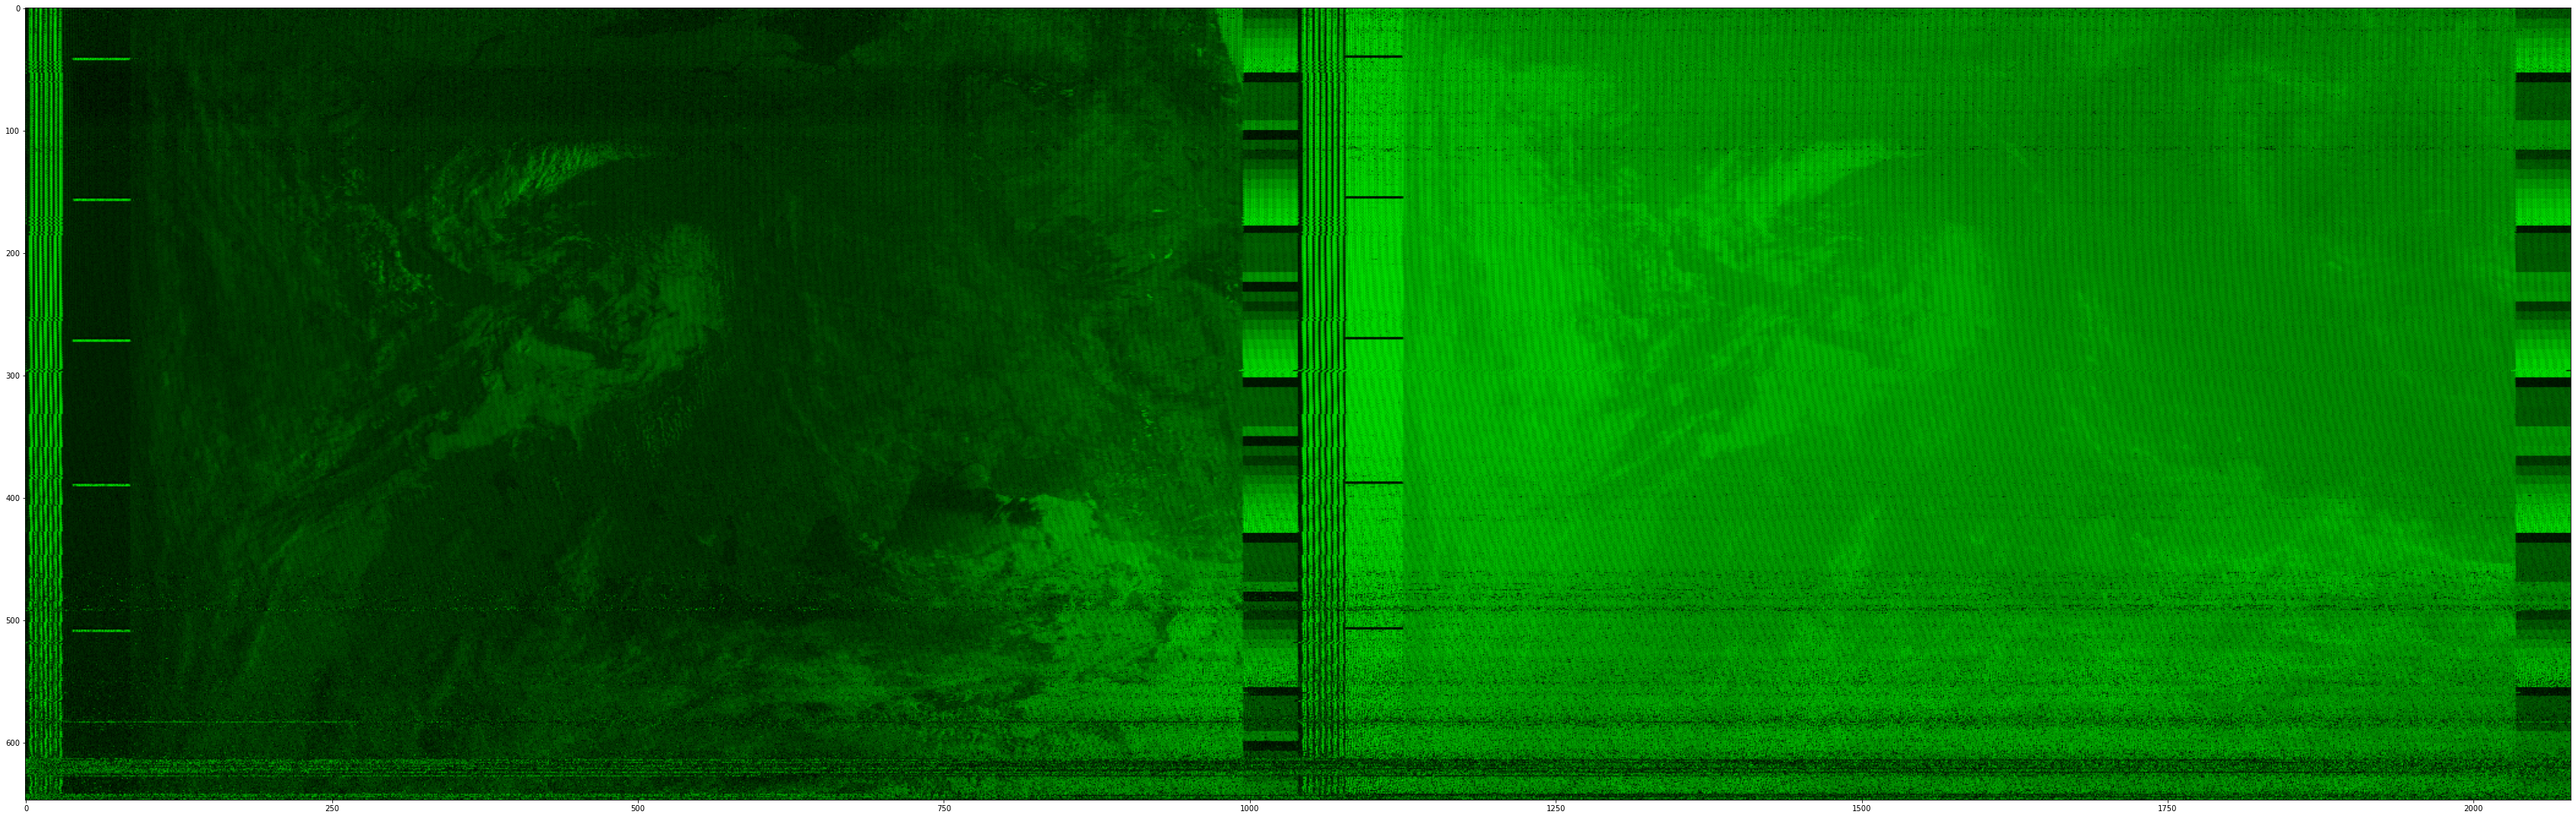

In [5]:
image = load_image("python_demod/image.npy", 2080)

fig = plt.figure(figsize=(60, 40))
ax = fig.add_subplot(111)

plt.imshow(image)
plt.show()

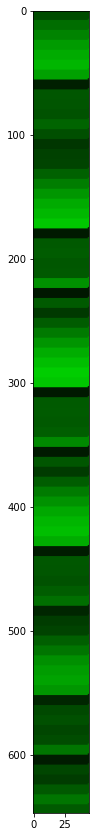

In [6]:
wedge = load_image("python_demod/w1.npy", 45)

fig = plt.figure(figsize=(1, 20))
ax = fig.add_subplot(111)

plt.imshow(wedge)
plt.show()

In [8]:
cadres = _get_telemetry_cadres(7, wedge)
ce, cadr = _get_brightness(180,20, cadres, image)
te = get_te(ce, cadr)

RGB = [0 123 0]
Номер кадра = 1
Кадр = [65, 68, 97, 125, 150, 171, 184, 199, 26, 89, 92, 87, 89, 145, 23, 90]
Номер клина для этого пикселя = 3

T_bb = 281.18916182648275
N_bb = 0.27660811540753305
Cbb = 89.25
Cspace = 23

Te = 329.4044198934266 К
Te = 56.40441989342662 C
